#### LORA

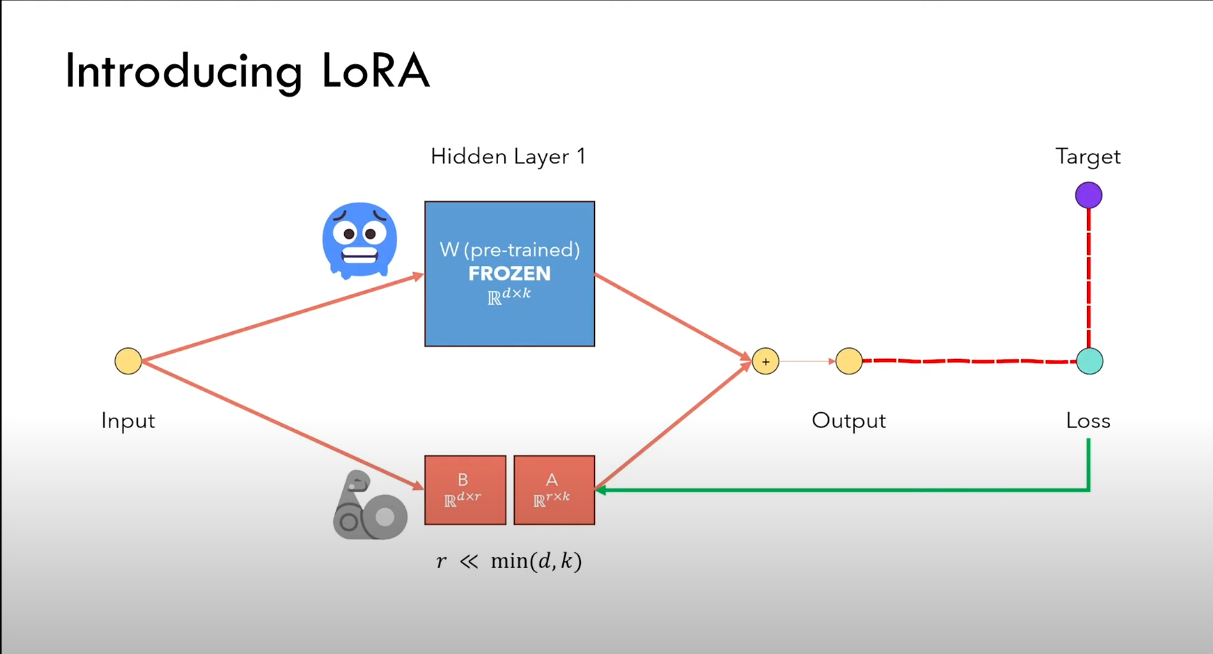

##### - Here we can decide the r if r = 5 then the matrices would become (d x 5) @ (5 x k) 

In [ ]:
import torch
import numpy as np
_ = torch.manual_seed(0)

#### Generate a rank-deficient matrix W

In [3]:
d, k = 10, 10

# This way we can generate a rank-deficient matrix
W_rank = 2
W =  torch.randn(d, W_rank) @ torch.randn(W_rank, k)
print(W)

tensor([[-1.0797,  0.5545,  0.8058, -0.7140, -0.1518,  1.0773,  2.3690,  0.8486,
         -1.1825, -3.2632],
        [-0.3303,  0.2283,  0.4145, -0.1924, -0.0215,  0.3276,  0.7926,  0.2233,
         -0.3422, -0.9614],
        [-0.5256,  0.9864,  2.4447, -0.0290,  0.2305,  0.5000,  1.9831, -0.0311,
         -0.3369, -1.1376],
        [ 0.7900, -1.1336, -2.6746,  0.1988, -0.1982, -0.7634, -2.5763, -0.1696,
          0.6227,  1.9294],
        [ 0.1258,  0.1458,  0.5090,  0.1768,  0.1071, -0.1327, -0.0323, -0.2294,
          0.2079,  0.5128],
        [ 0.7697,  0.0050,  0.5725,  0.6870,  0.2783, -0.7818, -1.2253, -0.8533,
          0.9765,  2.5786],
        [ 1.4157, -0.7814, -1.2121,  0.9120,  0.1760, -1.4108, -3.1692, -1.0791,
          1.5325,  4.2447],
        [-0.0119,  0.6050,  1.7245,  0.2584,  0.2528, -0.0086,  0.7198, -0.3620,
          0.1865,  0.3410],
        [ 1.0485, -0.6394, -1.0715,  0.6485,  0.1046, -1.0427, -2.4174, -0.7615,
          1.1147,  3.1054],
        [ 0.9088,  

##### Calculate the SVD decomposition of the W matrix

In [8]:
# perfrom SVD on W (W = UxSxV^T)
U, S, V = torch.svd(W)

U_r = U[:, :W_rank]
S_r = torch.diag(S[:W_rank])
V_r = V[:, :W_rank].t()

# Compute C = U_r * S_r and R = V_r
B = U_r @ S_r
A = V_r
print(f"shape of B: {B.shape}\n Shape of A: {A.shape}")

shape of B: torch.Size([10, 2])
 Shape of A: torch.Size([2, 10])


In [9]:
# generate random bias and input
bias = torch.randn(d)
x = torch.randn(d)

# Compute y = Wx + b
y = W @ x + bias
# Compute y' = CRx + b
y_prime = (B @ A) @ x + bias

print("Original y using W:\n", y)
print("")
print("y computed using BA:\n", y_prime)

Original y using W:
 tensor([ 7.2684e+00,  2.3162e+00,  7.7151e+00, -1.0446e+01, -8.1639e-03,
        -3.7270e+00, -1.1146e+01,  2.0207e+00, -9.6258e+00, -4.1163e+00])

y computed using BA:
 tensor([ 7.2684e+00,  2.3162e+00,  7.7151e+00, -1.0446e+01, -8.1640e-03,
        -3.7270e+00, -1.1146e+01,  2.0207e+00, -9.6258e+00, -4.1163e+00])


#### Lorea

In [10]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

#### MaKE the model Deterministic

In [11]:
# Make torhc deterministic
_ = torch.manual_seed(0)

we will be training to classify MNIST digits and then fine-tune the network on a particular digit on which it doesn't perform well.

In [12]:
import torch.utils
import torch.utils.data


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307), (0.3081))])

# Load The MNIST dataset
minist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Create a dataloader for the training
train_dl = torch.utils.data.DataLoader(minist_trainset, batch_size=10, shuffle=True)

# Load the MNIST test set
mnist_testset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_dl = torch.utils.data.DataLoader(mnist_testset, batch_size=20, shuffle=True)

# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:992)>



100%|██████████| 9912422/9912422 [00:11<00:00, 872892.14it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:992)>



100%|██████████| 28881/28881 [00:00<00:00, 106117.89it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:992)>



100%|██████████| 1648877/1648877 [00:03<00:00, 466524.04it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:992)>



100%|██████████| 4542/4542 [00:00<00:00, 4545580.71it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [14]:
# Create an overly expensive neural network to classify MNIST digits
class RichBoyNet(nn.Module):
    def __init__(self, hidden_size_1=1000, hidden_size_2=2000):
        super().__init__()
        self.linear1 = nn.Linear(28*28, hidden_size_1)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.linear3 = nn.Linear(hidden_size_2, 10)
        self.relu = nn.ReLU()

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

net = RichBoyNet()

In [15]:
def train(train_loader, net, epochs=5, total_iterations_limit=None):
    cross_el = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=0.001)

    total_iterations = 0

    for epoch in range(epochs):
        net.train()

        loss_sum = 0
        num_iterations = 0

        data_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        if total_iterations_limit is not None:
            data_iterator.total = total_iterations_limit
        for data in data_iterator:
            num_iterations += 1
            total_iterations += 1
            x, y = data
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = net(x.view(-1, 28*28))
            loss = cross_el(output, y)
            loss_sum += loss.item()
            avg_loss = loss_sum / num_iterations
            data_iterator.set_postfix(loss=avg_loss)
            loss.backward()
            optimizer.step()

            if total_iterations_limit is not None and total_iterations >= total_iterations_limit:
                return 
    
train(train_dl, net, epochs=1)

Epoch 1: 100%|██████████| 6000/6000 [03:16<00:00, 30.59it/s, loss=0.239]


In [16]:
original_weights = {}
for name, param in net.named_parameters():
    original_weights[name] = param.clone().detach()

In [17]:
def test():
    correct = 0
    total = 0
    
    wrong_counts = [0 for i in range(10)]

    with torch.no_grad():
        for data in tqdm(test_dl, desc="Testing"):
            x, y = data
            x, y = x.to(device), y.to(device)
            output = net(x.view(-1, 784))
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                else:
                    wrong_counts[y[idx]] += 1
                total += 1
    print(f"Accuracy: {round(correct/total, 3)}")
    for i in range(len(wrong_counts)):
        print(f"wrong counts for digit {i}: {wrong_counts[i]}")

test()

Testing: 100%|██████████| 500/500 [00:02<00:00, 171.22it/s]

Accuracy: 0.952
wrong counts for digit 0: 20
wrong counts for digit 1: 17
wrong counts for digit 2: 83
wrong counts for digit 3: 63
wrong counts for digit 4: 22
wrong counts for digit 5: 11
wrong counts for digit 6: 45
wrong counts for digit 7: 56
wrong counts for digit 8: 22
wrong counts for digit 9: 144


In [19]:
# Print the size fo weights metrics of the network
# Save the count of total numbers of parameters
total_parameters_original = 0
for index, layer in enumerate([net.linear1, net.linear2, net.linear3]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f"Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}" )
print(f"Total number of parameters: {total_parameters_original:,}")

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([10, 2000]) + B: torch.Size([10])
Total number of parameters: 2,807,010


#### Define the LoRA parameterization as described in the papaer

In [22]:
class LoRAParametrization(nn.Module):
    def __init__(self, features_in, features_out, rank=1, alpha=1, device='cpu'):
        super().__init__()
        self.rank, self.alpha = rank, alpha
        # Section 4.1 of the paper: 
            #   We use a random Gaussian initialization for A and zero for B, so ∆W = BA is zero at the beginning of training
        self.lora_A = nn.Parameter(torch.zeros((rank,features_out)).to(device))
        self.lora_B = nn.Parameter(torch.zeros((features_in, rank)).to(device))
        nn.init.normal_(self.lora_A, mean=0, std=1)
        
        # Section 4.1 of the paper: 
            #   We then scale ∆Wx by α/r , where α is a constant in r. 
            #   When optimizing with Adam, tuning α is roughly the same as tuning the learning rate if we scale the initialization appropriately. 
            #   As a result, we simply set α to the first r we try and do not tune it. 
            #   This scaling helps to reduce the need to retune hyperparameters when we vary r.
        self.scale = alpha / rank
        self.enabled = True

    def forward(self, original_weights):
        if self.enabled:
            # Return W + (B*A)*scale
            return original_weights + torch.matmul(self.lora_B, self.lora_A).view(original_weights.shape) * self.scale
        else:
            return original_weights

 ADD the parameterization to our network

In [23]:
import torch.nn.utils.parametrize as parametrize

def linear_layer_parameterization(layer, device, rank=1, lora_alpha=1):
    # Only add the parameterization to the weight matrix, ignore the Bias

    # From section 4.2 of the paper:
    #   We limit our study to only adapting the attention weights for downstream tasks and freeze the MLP modules (so they are not trained in downstream tasks) both for simplicity and parameter-efficiency.
    #   [...]
    #   We leave the empirical investigation of [...], and biases to a future work.
    
    features_in, features_out = layer.weight.shape
    return LoRAParametrization(
        features_in, features_out, rank=rank, alpha=lora_alpha, device=device
    )

parametrize.register_parametrization(
    net.linear1, "weight", linear_layer_parameterization(net.linear1, device)
)
parametrize.register_parametrization(
    net.linear2, "weight", linear_layer_parameterization(net.linear2, device)
)
parametrize.register_parametrization(
    net.linear3, "weight", linear_layer_parameterization(net.linear3, device)
)


def enable_disable_lora(enabled=True):
    for layer in [net.linear1, net.linear2, net.linear3]:
        layer.parametrizations["weight"][0].enabled = enabled

In [24]:
total_parameters_lora = 0
total_parameters_non_lora = 0
for index, layer in enumerate([net.linear1, net.linear2, net.linear3]):
    total_parameters_lora += layer.parametrizations["weight"][0].lora_A.nelement() + layer.parametrizations["weight"][0].lora_B.nelement()
    total_parameters_non_lora += layer.weight.nelement() + layer.bias.nelement()
    print(
        f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape} + Lora_A: {layer.parametrizations["weight"][0].lora_A.shape} + Lora_B: {layer.parametrizations["weight"][0].lora_B.shape}'
    )
# The non-LoRA parameters count must match the original network
assert total_parameters_non_lora == total_parameters_original
print(f'Total number of parameters (original): {total_parameters_non_lora:,}')
print(f'Total number of parameters (original + LoRA): {total_parameters_lora + total_parameters_non_lora:,}')
print(f'Parameters introduced by LoRA: {total_parameters_lora:,}')
parameters_incremment = (total_parameters_lora / total_parameters_non_lora) * 100
print(f'Parameters incremment: {parameters_incremment:.3f}%')

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000]) + Lora_A: torch.Size([1, 784]) + Lora_B: torch.Size([1000, 1])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000]) + Lora_A: torch.Size([1, 1000]) + Lora_B: torch.Size([2000, 1])
Layer 3: W: torch.Size([10, 2000]) + B: torch.Size([10]) + Lora_A: torch.Size([1, 2000]) + Lora_B: torch.Size([10, 1])
Total number of parameters (original): 2,807,010
Total number of parameters (original + LoRA): 2,813,804
Parameters introduced by LoRA: 6,794
Parameters incremment: 0.242%


In [25]:
# Freeze the non-Lora parameters
for name, param in net.named_parameters():
    if 'lora' not in name:
        print(f'Freezing non-LoRA parameter {name}')
        param.requires_grad = False

# Load the MNIST dataset again, by keeping only the digit 9
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
exclude_indices = mnist_trainset.targets == 9
mnist_trainset.data = mnist_trainset.data[exclude_indices]
mnist_trainset.targets = mnist_trainset.targets[exclude_indices]
# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

# Train the network with LoRA only on the digit 9 and only for 100 batches (hoping that it would improve the performance on the digit 9)
train(train_loader, net, epochs=1, total_iterations_limit=100)

Freezing non-LoRA parameter linear1.bias
Freezing non-LoRA parameter linear1.parametrizations.weight.original
Freezing non-LoRA parameter linear2.bias
Freezing non-LoRA parameter linear2.parametrizations.weight.original
Freezing non-LoRA parameter linear3.bias
Freezing non-LoRA parameter linear3.parametrizations.weight.original


Epoch 1:  99%|█████████▉| 99/100 [00:02<00:00, 37.09it/s, loss=0.139]


In [26]:
# Check that the frozen parameters are still unchanged by the finetuning
assert torch.all(net.linear1.parametrizations.weight.original == original_weights['linear1.weight'])
assert torch.all(net.linear2.parametrizations.weight.original == original_weights['linear2.weight'])
assert torch.all(net.linear3.parametrizations.weight.original == original_weights['linear3.weight'])

enable_disable_lora(enabled=True)
# The new linear1.weight is obtained by the "forward" function of our LoRA parametrization
# The original weights have been moved to net.linear1.parametrizations.weight.original
# More info here: https://pytorch.org/tutorials/intermediate/parametrizations.html#inspecting-a-parametrized-module
assert torch.equal(net.linear1.weight, net.linear1.parametrizations.weight.original + (net.linear1.parametrizations.weight[0].lora_B @ net.linear1.parametrizations.weight[0].lora_A) * net.linear1.parametrizations.weight[0].scale)

enable_disable_lora(enabled=False)
# If we disable LoRA, the linear1.weight is the original one
assert torch.equal(net.linear1.weight, original_weights['linear1.weight'])

In [27]:
# Test with LoRA enabled
enable_disable_lora(enabled=True)
test()

Testing: 100%|██████████| 500/500 [00:07<00:00, 67.55it/s]

Accuracy: 0.908
wrong counts for digit 0: 135
wrong counts for digit 1: 28
wrong counts for digit 2: 134
wrong counts for digit 3: 169
wrong counts for digit 4: 133
wrong counts for digit 5: 51
wrong counts for digit 6: 76
wrong counts for digit 7: 100
wrong counts for digit 8: 90
wrong counts for digit 9: 8


In [28]:
# Test with LoRA disabled
enable_disable_lora(enabled=False)
test()

Testing: 100%|██████████| 500/500 [00:03<00:00, 132.89it/s]

Accuracy: 0.952
wrong counts for digit 0: 20
wrong counts for digit 1: 17
wrong counts for digit 2: 83
wrong counts for digit 3: 63
wrong counts for digit 4: 22
wrong counts for digit 5: 11
wrong counts for digit 6: 45
wrong counts for digit 7: 56
wrong counts for digit 8: 22
wrong counts for digit 9: 144
